In [6]:
import pandas as pd
pd.set_option('display.max_columns', None)
import requests
from bs4 import BeautifulSoup
import re
# import geopy # https://github.com/shakasom/geocoding/blob/master/geocoding.ipynb
from geopy.geocoders import Nominatim
# import json
import geopy.distance
import numpy as np
# import itertools
import shapely.geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib as mpl
# import tabula
# import datetime as dt

In [7]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [8]:
# Projected Coordinate System (PCS): how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System (GCS): how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# Load neighbourhood crime rates and rental costs
- about https://data.torontopolice.on.ca/datasets/TorontoPS::neighbourhood-crime-rates-2020-1/about 
- Neighbourhood GeoJSON file https://opendata.arcgis.com/api/v3/datasets/3a1a9c98146e470e94e814b0e3a3fbca_0/downloads/data?format=geojson&spatialRefId=4326
- *Population figures reflect only the resident population of a region. The temporary population such as the commuters and business patrons are not included.

In [9]:
neighbourhoods = gpd.read_file('../data/raw/Neighbourhood_Boundary.geojson')
neighbourhoods.rename(columns={'hoodname': 'neighbourhood'}, inplace=True)
neighbourhoods.head()

,object_id,neighbourhood,hood_id,f2021populationprojection,assault2014,assault2015,assault2016,assault2017,assault2018,assault2019,assault2020,assault2021,assaultrate2014,assaultrate2015,assaultrate2016,assaultrate2017,assaultrate2018,assaultrate2019,assaultrate2020,assaultrate2021,autotheft2014,autotheft2015,autotheft2016,autotheft2017,autotheft2018,autotheft2019,autotheft2020,autotheft2021,autotheftrate2014,autotheftrate2015,autotheftrate2016,autotheftrate2017,autotheftrate2018,autotheftrate2019,autotheftrate2020,autotheftrate2021,breakandenter2014,breakandenter2015,breakandenter2016,breakandenter2017,breakandenter2018,breakandenter2019,breakandenter2020,breakandenter2021,breakandenterrate2014,breakandenterrate2015,breakandenterrate2016,breakandenterrate2017,breakandenterrate2018,breakandenterrate2019,breakandenterrate2020,breakandenterrate2021,robbery2014,robbery2015,robbery2016,robbery2017,robbery2018,robbery2019,robbery2020,robbery2021,robberyrate2014,robberyrate2015,robberyrate2016,robberyrate2017,robberyrate2018,robberyrate2019,robberyrate2020,robberyrate2021,theftover2014,theftover2015,theftover2016,theftover2017,theftover2018,theftover2019,theftover2020,theftover2021,theftoverrate2014,theftoverrate2015,theftoverrate2016,theftoverrate2017,theftoverrate2018,theftoverrate2019,theftoverrate2020,theftoverrate2021,homicide2014,homicide2015,homicide2016,homicide2017,homicide2018,homicide2019,homicide2020,homicide2021,homiciderate2014,homiciderate2015,homiciderate2016,homiciderate2017,homiciderate2018,homiciderate2019,homiciderate2020,homiciderate2021,shootings2014,shootings2015,shootings2016,shootings2017,shootings2018,shootings2019,shootings2020,shootings2021,shootingrate2014,shootingsrate2015,shootingsrate2016,shootingsrate2017,shootingsrate2018,shootingsrate2019,shootingsrate2020,shootingsrate2021,theftfrommotorvehicle2014,theftfrommotorvehicle2015,theftfrommotorvehicle2016,theftfrommotorvehicle2017,theftfrommotorvehicle2018,theftfrommotorvehicle2019,theftfrommotorvehicle2020,theftfrommotorvehicle2021,theftfrommotorvehiclerate2014,theftfrommotorvehiclerate2015,theftfrommotorvehiclerate2016,theftfrommotorvehiclerate2017,theftfrommotorvehiclerate2018,theftfrommotorvehiclerate2019,theftfrommotorvehiclerate2020,theftfrommotorvehiclerate2021,geometry
0,1,Yonge-St.Clair,097,14362,16,25,34,25,28,35,23,55,127.0144,196.1246,262.5482,189.1790,207.2846,253.8071,163.3175,382.9550,2,3,7,2,6,6,9,14,15.8768,23.53495,54.05405,15.13432,44.41812,43.50979,63.90684,97.47946,37,20,12,18,24,28,27,30,293.7207,156.8997,92.66409,136.2088,177.6725,203.0457,191.7205,208.88460,4,1,6,1,1,4,5,5,31.75359,7.844983,46.33205,7.567159,7.40302,29.00653,35.50380,34.81409,3,5,7,0,3,6,3,3,23.81519,39.22491,54.05405,0.00000,22.20906,43.50979,21.30228,20.88846,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,0,0,0,0,0,0.000000,0.000000,7.722008,0.000000,0.000000,0.000000,0.000000,0.000000,8,11,8,7,23,22,20,23,63.50718,86.29482,61.77606,52.97011,170.2695,159.5359,142.0152,160.144827,"POLYGON ((-79.39118 43.68108, -79.39139 43.680..."
1,2,York University Heights,027,30660,273,298,363,351,362,382,348,339,950.5571,1041.4850,1269.3200,1211.0970,1230.3300,1279.8610,1149.3870,1105.6750,109,100,109,91,92,147,187,172,379.5265,349.49150,381.14550,313.98800,312.68050,492.51180,617.63060,560.99150,108,140,98,105,122,111,105,115,376.0446,489.2881,342.68130,362.2938,414.6416,371.8967,346.7979,375.08150,58,85,70,76,94,84,48,40,201.94990,297.067800,244.77240,262.231700,319.47800,281.43530,158.53620,130.46320,30,46,38,40,38,31,42,33,104.45680,160.76610,132.87640,138.01670,129.15070,103.86300,138.71920,107.63210,1,0,2,0,1,0,1,6,3.481894,0.000000,6.993496,0.000000,0.000000,0.000000,3.302837,19.569472,2,0,4,10,8,6,12,13,6.963789,0.000000,13.986990,34.504170,27.189610,20.102520,39.634040,42.400522,142,123,138,163,174,161,262,204,494.42900,429.87450,482.55120,562.41800,591.3741,539.4177,865.3433,665.362035,"POLYGON ((-79.50527 43.75987, -7

In [10]:
# number of neighbourhoods
len(neighbourhoods.hood_id.unique())

140

In [11]:
# remove leading zeros in hood_id
neighbourhoods['hood_id'] = neighbourhoods['hood_id'].str.lstrip('0')

<AxesSubplot:>

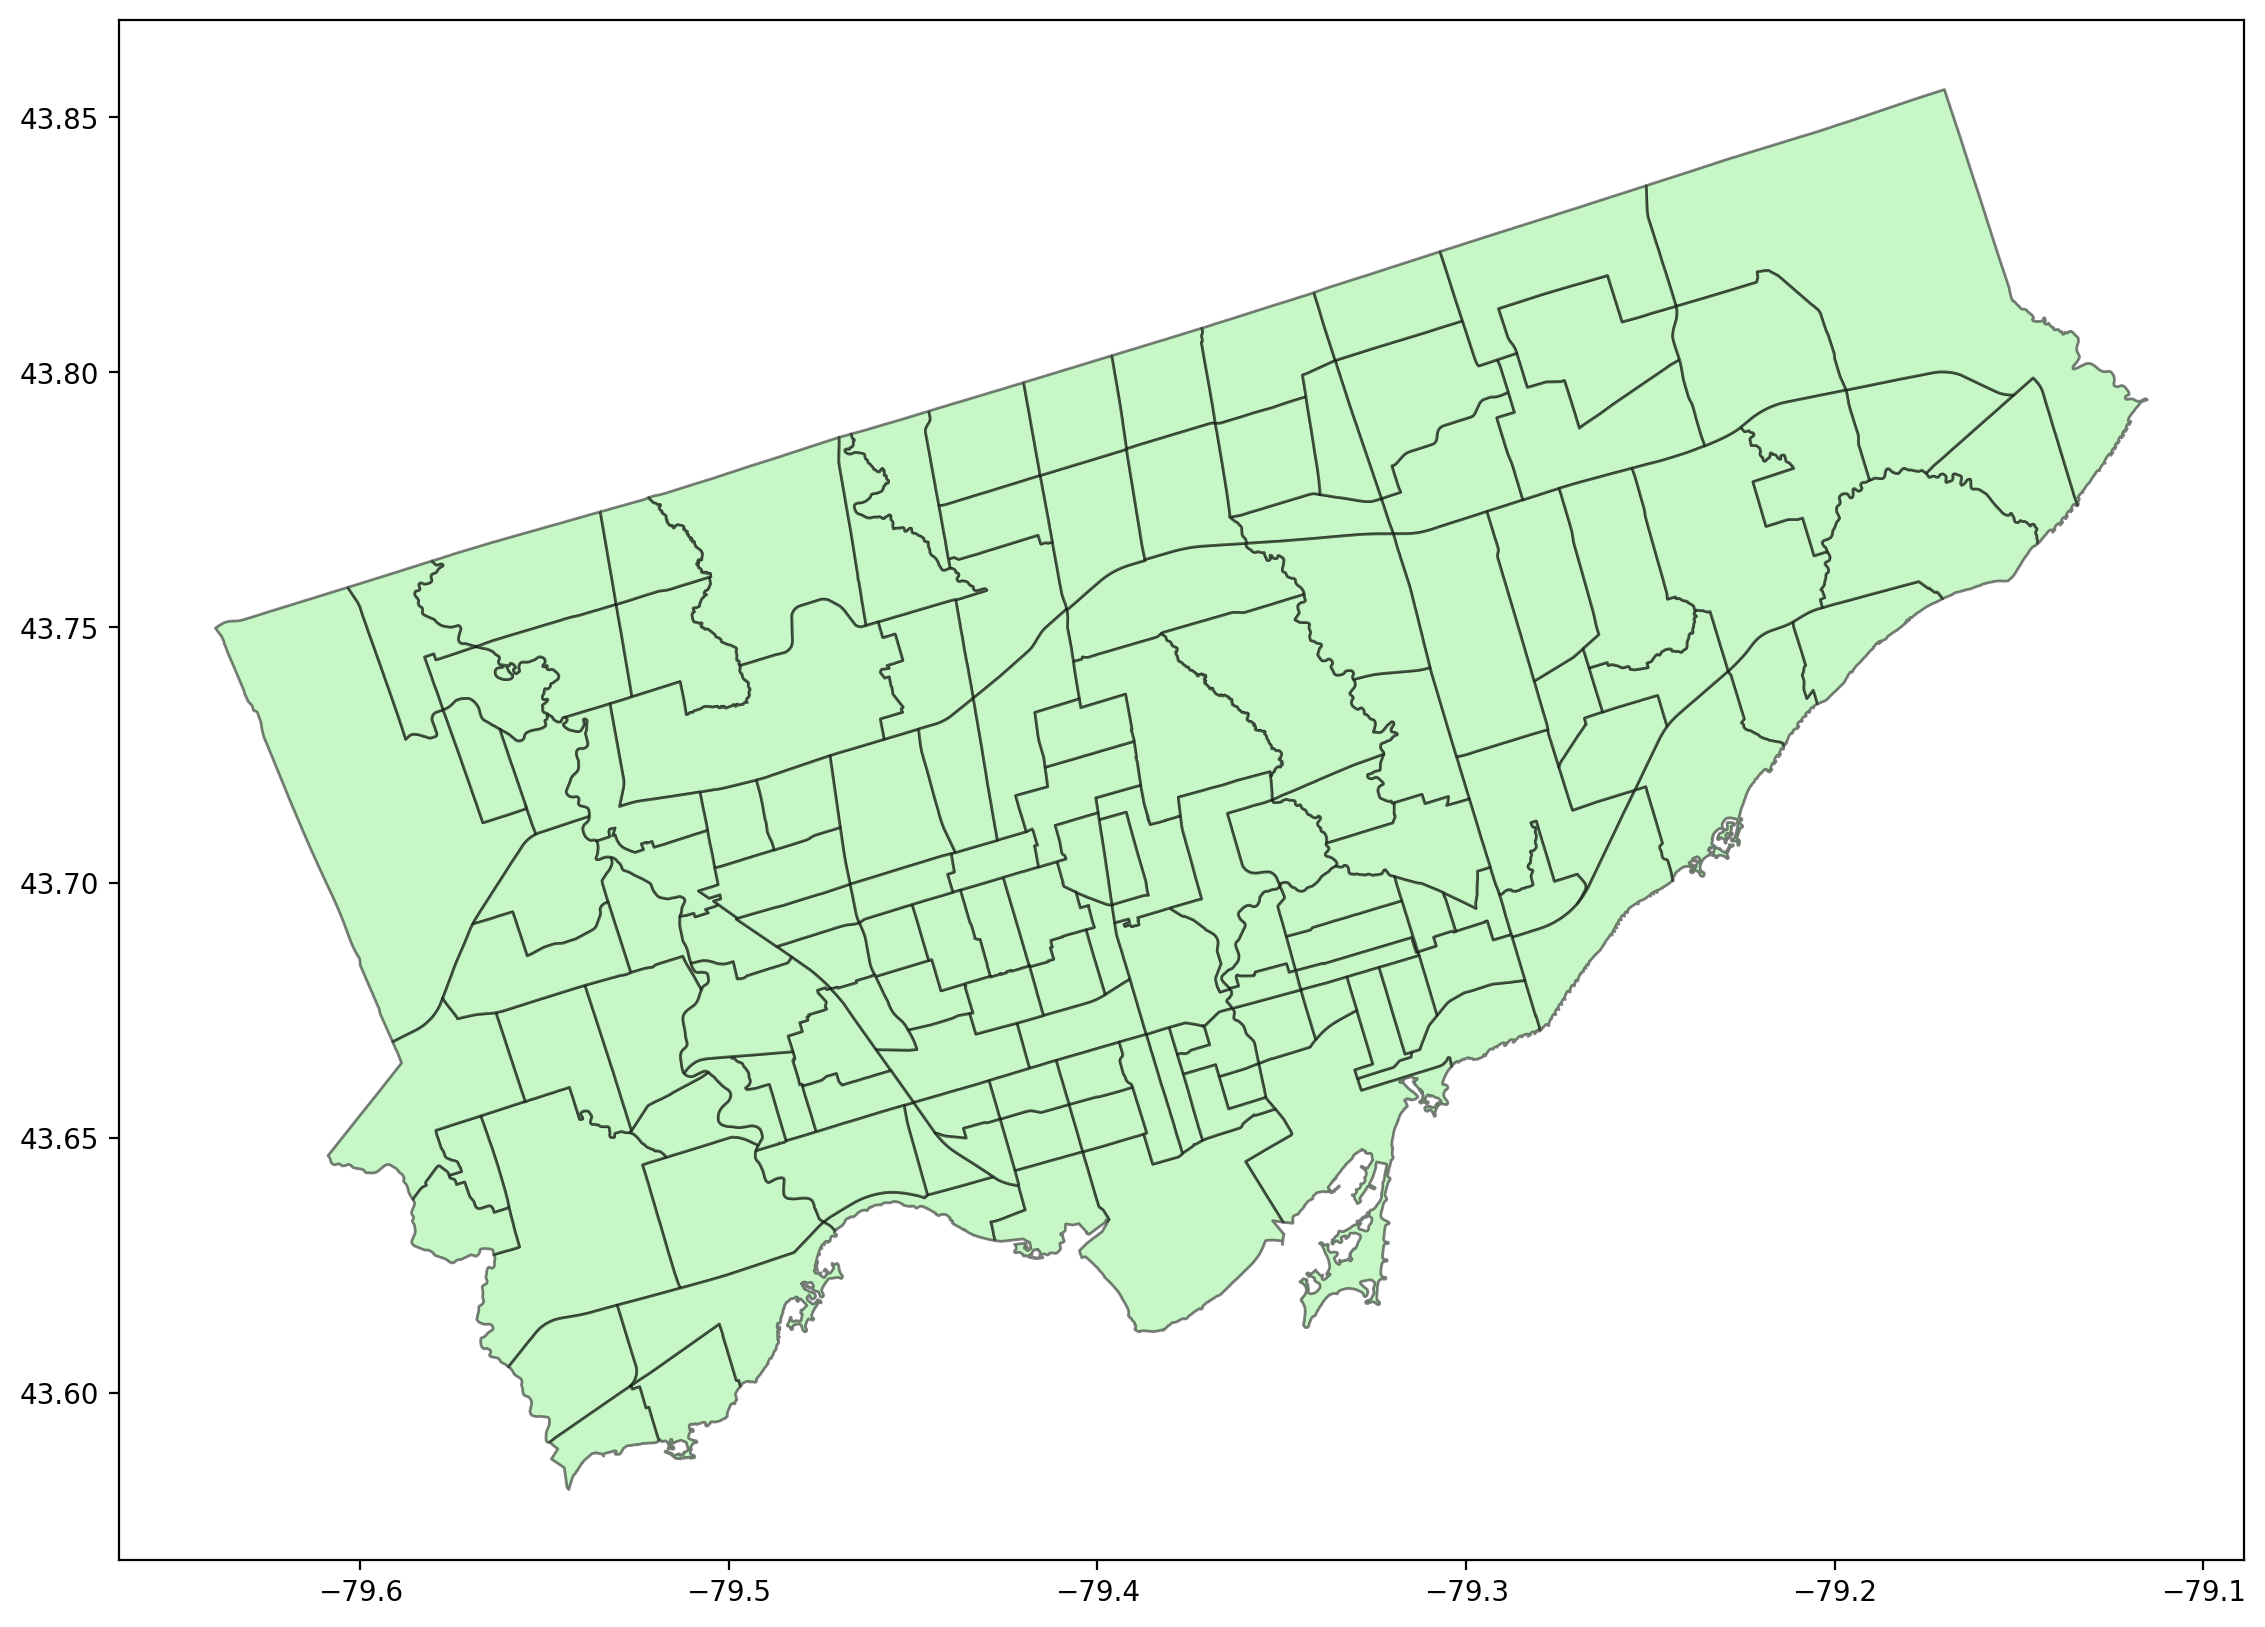

In [12]:
neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)

## Mapping between MLS municipality and neighbourhood

While we have the boundary files for neighbourhood, the apartment rental data from TRREB are only availble to the level of municipalities defined by MLS. Therefore we need to link the two together.

In [13]:
# get mapping between neighbourhood and MLS municipalities
r = requests.get('https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Toronto#Multiple_listing_service_districts_and_neighbourhoods')
soup = BeautifulSoup(r.text)
table = soup.find('table', {'class' : 'wikitable sortable'})
df = pd.read_html(str(table))[0]

district_neighbourhood = {}

for key, value in df.set_index('District Number').to_dict()['Neighbourhoods Included'].items():
    for x in value.split(','):
        district_neighbourhood[x.strip()] = key
        
district_neighbourhood

{'Downtown': 'C01',
 'Harbourfront': 'C01',
 'Little Italy': 'C01',
 'Little Portugal': 'C01',
 'Dufferin Grove': 'C01',
 'Palmerston': 'C01',
 'University': 'C01',
 'Bay Street Corridor': 'C01',
 'Kensington Market': 'C01',
 'Chinatown': 'C01',
 'Trinity Bellwoods': 'C01',
 'South Niagara': 'C01',
 'Island airport': 'C01',
 'The Islands': 'C01',
 'waterfront communities C1': 'C01',
 "Queen's Park": 'C01',
 'Ontario Provincial Government': 'C01',
 'Victoria Hotel': 'C01',
 'Central Bay Street': 'C01',
 'First Canadian Place': 'C01',
 'Design Exchange': 'C01',
 'Adelaide': 'C01',
 'Union Station': 'C01',
 'The Annex': 'C02',
 'Yorkville': 'C02',
 'South Hill': 'C02',
 'Summerhill': 'C02',
 'Wychwood Park': 'C02',
 'Deer Park': 'C02',
 'Casa Loma': 'C02',
 'Forest Hill South': 'C03',
 'Oakwood–Vaughan': 'C03',
 'Humewood–Cedarvale': 'C03',
 'Corso Italia': 'W03',
 'Forest Hill Road Park': 'C03',
 'Bedford Park': 'C04',
 'Lawrence Manor': 'C04',
 'North Toronto': 'C04',
 'Forest Hill Nort

In [14]:
neighbourhoods['district'] = neighbourhoods.apply(lambda x: district_neighbourhood.get(x['neighbourhood'], np.nan), axis = 1).fillna("NA")

In [15]:
# use plotly to check which neighbourhood does not have a corresponding district code
# fig = px.choropleth(neighbourhoods,
#               geojson=neighbourhoods.geometry,
#               locations=neighbourhoods.index,
#               color = 'district',
#               hover_data=['Neighbourhood', "hood_id"])
# fig.update_geos(fitbounds="locations", visible=False)

In [16]:
# resource from Jackie Carron and Fred Skogland: 
# https://carronskogland.com/maps/realestatemap_toronto.pdf
my_map = {
    'C01': ['81','82','80','78','77'], 'C02': ['95','94','97'],
    'C03': ['106', '107','100'], 'C04': ['102', '32', '39','105','103'],
    'C07': ['35'], 'C08': ['75','74','71'], 'C09': ['98'], 'C10': ['104','99'],
    'C11': ['56'], 'C12': ['41','40'], 'C13': ['42','45'],
    'E01': ['68','70','65'], 'E02': ['62'], 'E03': ['67','57','58','59','66','60','54','61'],
    'E04': ['120','124','119'], 'E05': ['118'], 'E06': ['121','122'], 'E07': ['128', '129'],
    'E08': ['138'], 'E09': ['127'], 'E10': ['133'],
    'W01': ['87'], 'W02': ['93','90','89','114'], 'W03': ['92','109','110','111'], 
    'W04': ['112','30','23','31','108'], 'W05': ['23','22','25','24'], 'W06': ['17'],
    'W07': ['16'], 'W08': ['14','15','13','11'], 'W09':['7','8'],
    'W10': ['1','2','3','4','5']
}

In [17]:
district_hoodID = {}
for key, value in my_map.items():
    for x in value:
        district_hoodID[x] = key
district_hoodID

{'81': 'C01',
 '82': 'C01',
 '80': 'C01',
 '78': 'C01',
 '77': 'C01',
 '95': 'C02',
 '94': 'C02',
 '97': 'C02',
 '106': 'C03',
 '107': 'C03',
 '100': 'C03',
 '102': 'C04',
 '32': 'C04',
 '39': 'C04',
 '105': 'C04',
 '103': 'C04',
 '35': 'C07',
 '75': 'C08',
 '74': 'C08',
 '71': 'C08',
 '98': 'C09',
 '104': 'C10',
 '99': 'C10',
 '56': 'C11',
 '41': 'C12',
 '40': 'C12',
 '42': 'C13',
 '45': 'C13',
 '68': 'E01',
 '70': 'E01',
 '65': 'E01',
 '62': 'E02',
 '67': 'E03',
 '57': 'E03',
 '58': 'E03',
 '59': 'E03',
 '66': 'E03',
 '60': 'E03',
 '54': 'E03',
 '61': 'E03',
 '120': 'E04',
 '124': 'E04',
 '119': 'E04',
 '118': 'E05',
 '121': 'E06',
 '122': 'E06',
 '128': 'E07',
 '129': 'E07',
 '138': 'E08',
 '127': 'E09',
 '133': 'E10',
 '87': 'W01',
 '93': 'W02',
 '90': 'W02',
 '89': 'W02',
 '114': 'W02',
 '92': 'W03',
 '109': 'W03',
 '110': 'W03',
 '111': 'W03',
 '112': 'W04',
 '30': 'W04',
 '23': 'W05',
 '31': 'W04',
 '108': 'W04',
 '22': 'W05',
 '25': 'W05',
 '24': 'W05',
 '17': 'W06',
 '16': 'W0

In [18]:
neighbourhoods['district'] = neighbourhoods.apply(lambda x: district_hoodID.get(x['hood_id'], x['district']) , axis = 1)

Text(0.5, 1.0, 'MLS districts in Toronto containing neighbourhoods')

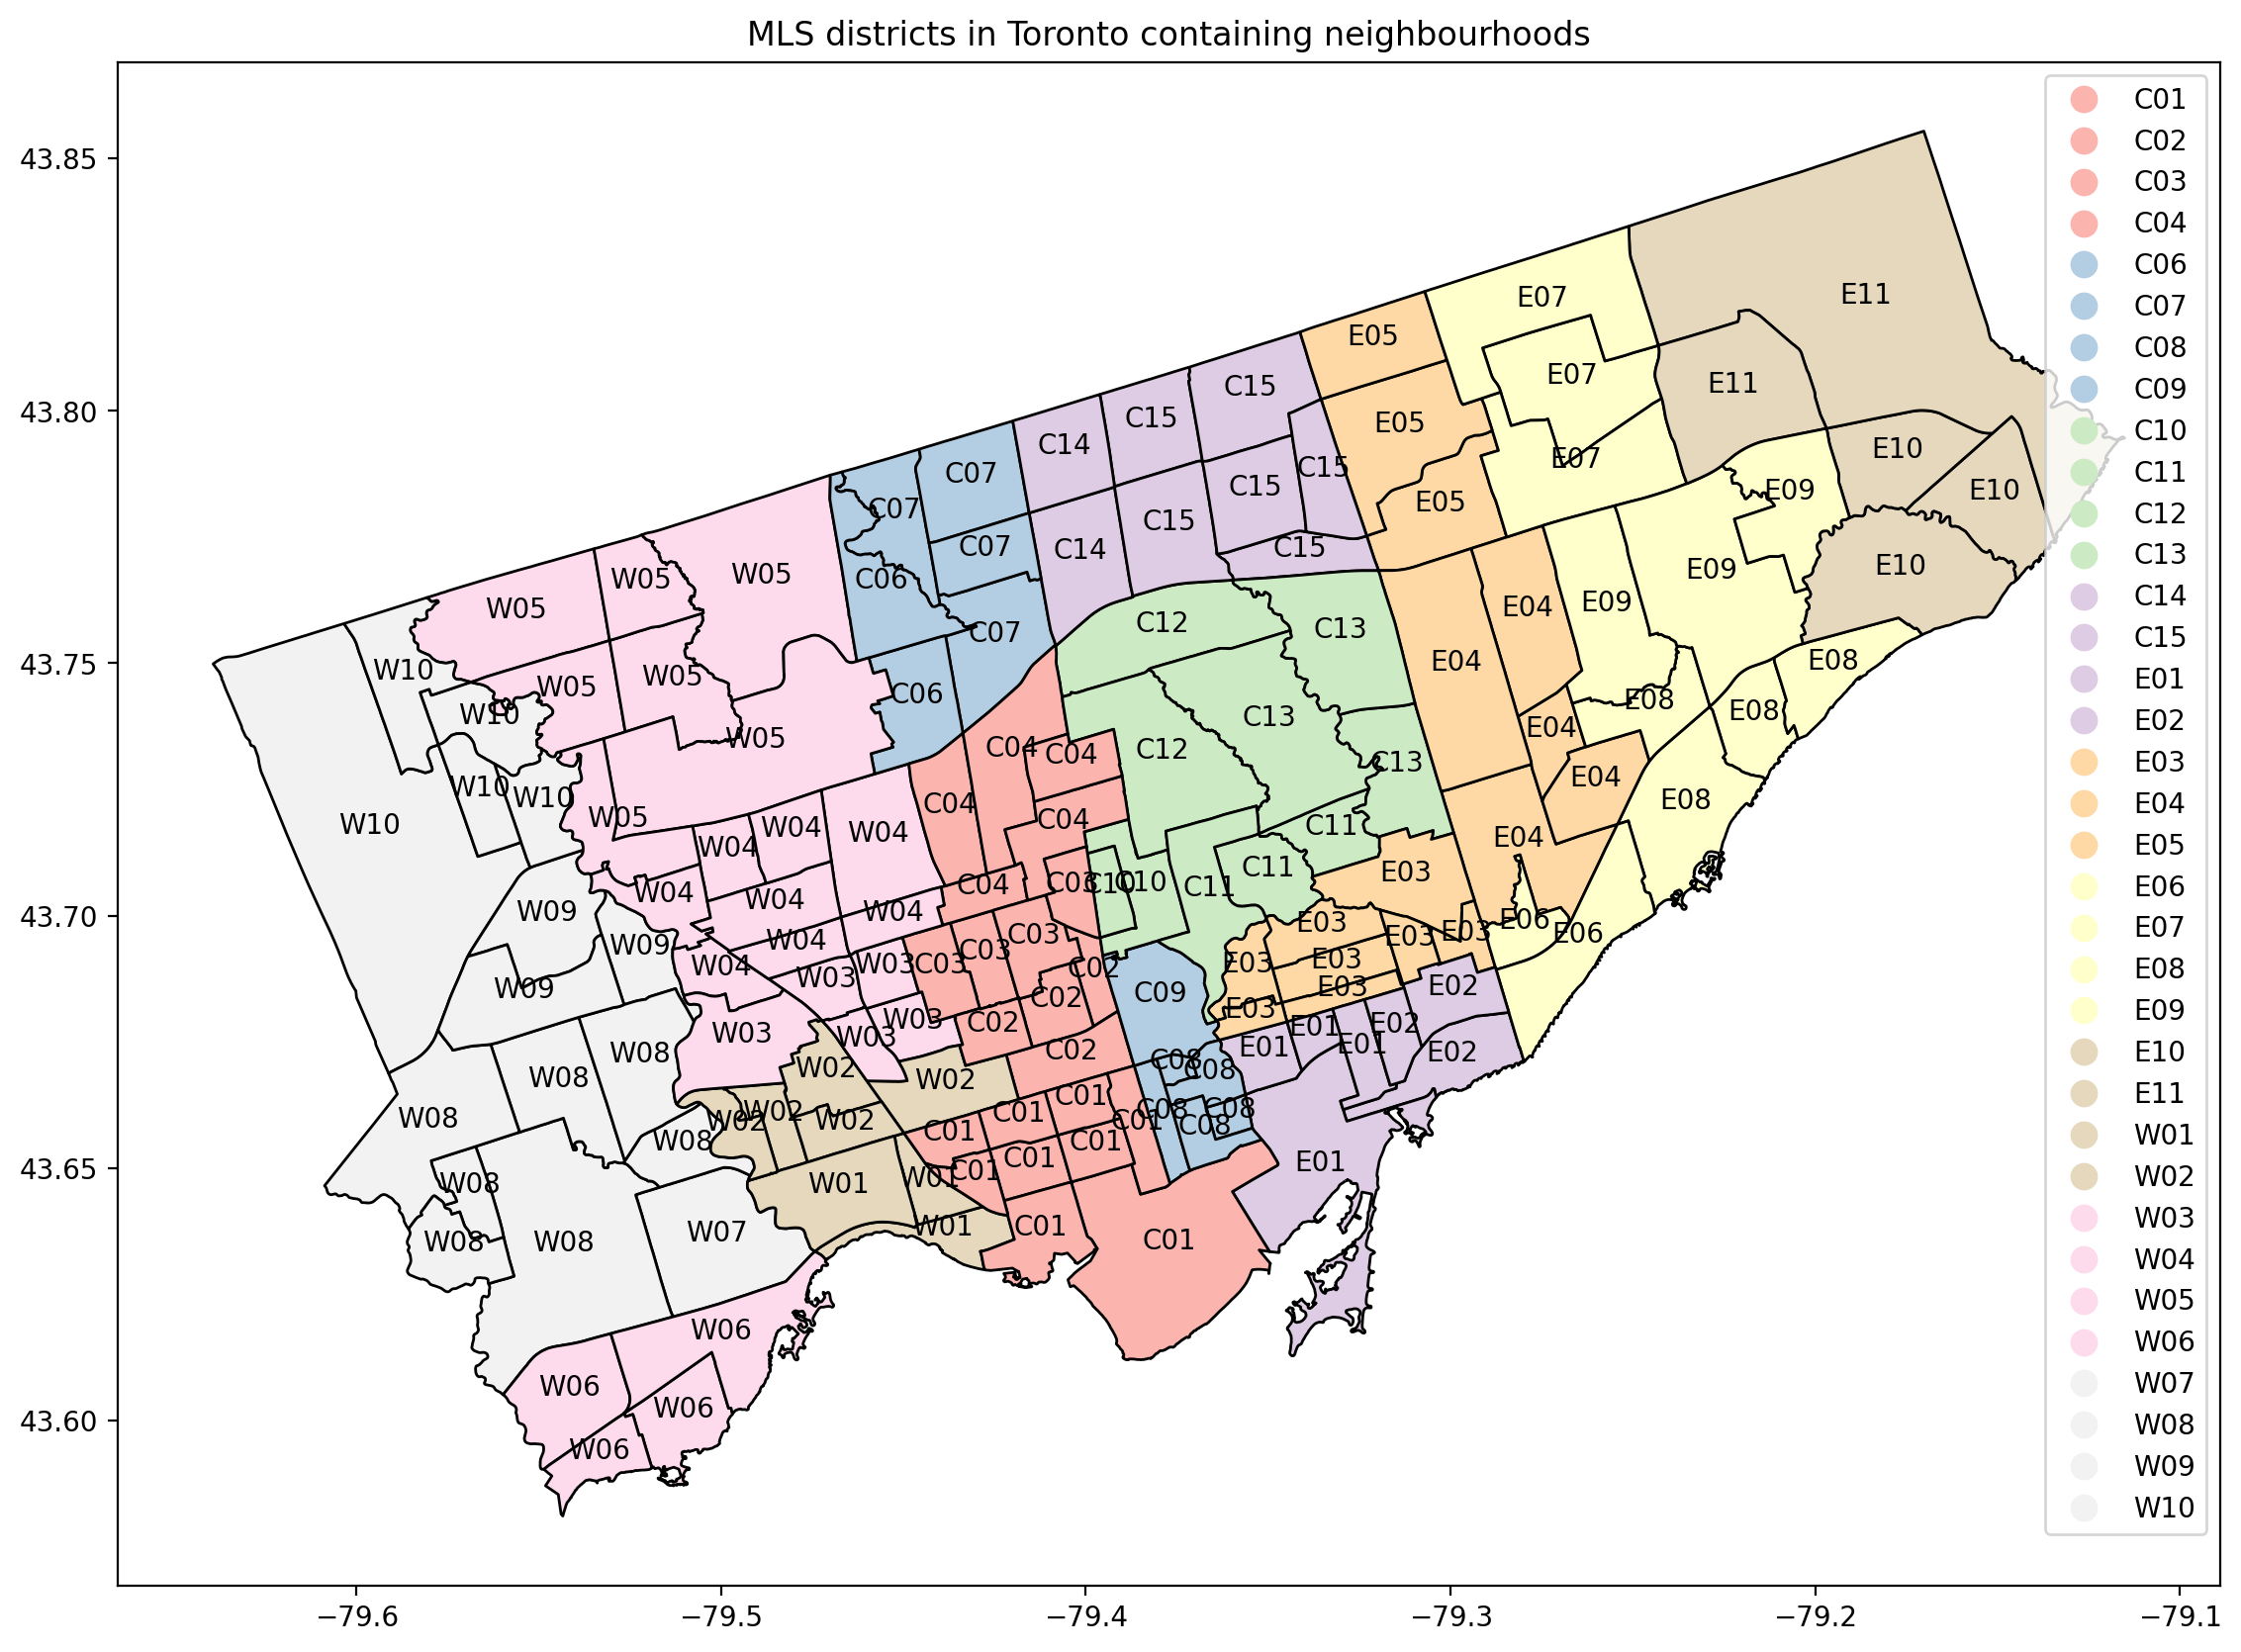

In [19]:
# now we have the complete mapping, with each MLS municipality containing a number of neighbourhoods
cmap_big = mpl.cm.get_cmap('Pastel1', 35)
newcmp = mpl.colors.ListedColormap(cmap_big(np.linspace(0, 1, 35)))

ax = neighbourhoods.plot(column = 'district',
                   legend = True,
                   cmap = newcmp,
                   edgecolor = 'black')

for geometry, label in zip(neighbourhoods.geometry, neighbourhoods.district):
    ax.annotate(label, xy=(geometry.centroid.x, geometry.centroid.y), ha='center')

ax.set_title('MLS districts in Toronto containing neighbourhoods')

In [20]:
neighbourhoods

,object_id,neighbourhood,hood_id,f2021populationprojection,assault2014,assault2015,assault2016,assault2017,assault2018,assault2019,assault2020,assault2021,assaultrate2014,assaultrate2015,assaultrate2016,assaultrate2017,assaultrate2018,assaultrate2019,assaultrate2020,assaultrate2021,autotheft2014,autotheft2015,autotheft2016,autotheft2017,autotheft2018,autotheft2019,autotheft2020,autotheft2021,autotheftrate2014,autotheftrate2015,autotheftrate2016,autotheftrate2017,autotheftrate2018,autotheftrate2019,autotheftrate2020,autotheftrate2021,breakandenter2014,breakandenter2015,breakandenter2016,breakandenter2017,breakandenter2018,breakandenter2019,breakandenter2020,breakandenter2021,breakandenterrate2014,breakandenterrate2015,breakandenterrate2016,breakandenterrate2017,breakandenterrate2018,breakandenterrate2019,breakandenterrate2020,breakandenterrate2021,robbery2014,robbery2015,robbery2016,robbery2017,robbery2018,robbery2019,robbery2020,robbery2021,robberyrate2014,robberyrate2015,robberyrate2016,robberyrate2017,robberyrate2018,robberyrate2019,robberyrate2020,robberyrate2021,theftover2014,theftover2015,theftover2016,theftover2017,theftover2018,theftover2019,theftover2020,theftover2021,theftoverrate2014,theftoverrate2015,theftoverrate2016,theftoverrate2017,theftoverrate2018,theftoverrate2019,theftoverrate2020,theftoverrate2021,homicide2014,homicide2015,homicide2016,homicide2017,homicide2018,homicide2019,homicide2020,homicide2021,homiciderate2014,homiciderate2015,homiciderate2016,homiciderate2017,homiciderate2018,homiciderate2019,homiciderate2020,homiciderate2021,shootings2014,shootings2015,shootings2016,shootings2017,shootings2018,shootings2019,shootings2020,shootings2021,shootingrate2014,shootingsrate2015,shootingsrate2016,shootingsrate2017,shootingsrate2018,shootingsrate2019,shootingsrate2020,shootingsrate2021,theftfrommotorvehicle2014,theftfrommotorvehicle2015,theftfrommotorvehicle2016,theftfrommotorvehicle2017,theftfrommotorvehicle2018,theftfrommotorvehicle2019,theftfrommotorvehicle2020,theftfrommotorvehicle2021,theftfrommotorvehiclerate2014,theftfrommotorvehiclerate2015,theftfrommotorvehiclerate2016,theftfrommotorvehiclerate2017,theftfrommotorvehiclerate2018,theftfrommotorvehiclerate2019,theftfrommotorvehiclerate2020,theftfrommotorvehiclerate2021,geometry,district
0,1,Yonge-St.Clair,97,14362,16,25,34,25,28,35,23,55,127.0144,196.1246,262.5482,189.1790,207.2846,253.8071,163.3175,382.9550,2,3,7,2,6,6,9,14,15.87680,23.53495,54.05405,15.13432,44.41812,43.50979,63.90684,97.47946,37,20,12,18,24,28,27,30,293.7207,156.8997,92.66409,136.20880,177.6725,203.0457,191.7205,208.88460,4,1,6,1,1,4,5,5,31.75359,7.844983,46.33205,7.567159,7.40302,29.00653,35.50380,34.81409,3,5,7,0,3,6,3,3,23.81519,39.224910,54.05405,0.00000,22.20906,43.50979,21.30228,20.88846,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,0,0,0,0,0,0.000000,0.000000,7.722008,0.000000,0.000000,0.000000,0.000000,0.000000,8,11,8,7,23,22,20,23,63.50718,86.29482,61.77606,52.97011,170.2695,159.5359,142.0152,160.144827,"POLYGON ((-79.39118 43.68108, -79.39139 43.680...",C02
1,2,York University Heights,27,30660,273,298,363,351,362,382,348,339,950.5571,1041.4850,1269.3200,1211.0970,1230.3300,1279.8610,1149.3870,1105.6750,109,100,109,91,92,147,187,172,379.52650,349.49150,381.14550,313.98800,312.68050,492.51180,617.63060,560.99150,108,140,98,105,122,111,105,115,376.0446,489.2881,342.68130,362.29380,414.6416,371.8967,346.7979,375.08150,58,85,70,76,94,84,48,40,201.94990,297.067800,244.77240,262.231700,319.47800,281.43530,158.53620,130.46320,30,46,38,40,38,31,42,33,104.45680,160.766100,132.87640,138.01670,129.15070,103.86300,138.71920,107.63210,1,0,2,0,1,0,1,6,3.481894,0.000000,6.993496,0.000000,0.000000,0.000000,3.302837,19.569472,2,0,4,10,8,6,12,13,6.963789,0.000000,13.986990,34.504170,27.189610,20.102520,39.634040,42.400522,142,123,138,163,174,161,262,204,494.42900,429.87450,482.55120,562.41800,591.3741,539.4177,865.3433,665.362035,"POLYGON ((-79.5

In [21]:
print(len(neighbourhoods.district.unique()))
print(len(neighbourhoods.hood_id.unique()))
print(len(neighbourhoods.neighbourhood.unique()))

35
140
140


## Fixing crime counts and crime rates

In [22]:
neighbourhoods.columns.values

array(['object_id', 'neighbourhood', 'hood_id',
       'f2021populationprojection', 'assault2014', 'assault2015',
       'assault2016', 'assault2017', 'assault2018', 'assault2019',
       'assault2020', 'assault2021', 'assaultrate2014', 'assaultrate2015',
       'assaultrate2016', 'assaultrate2017', 'assaultrate2018',
       'assaultrate2019', 'assaultrate2020', 'assaultrate2021',
       'autotheft2014', 'autotheft2015', 'autotheft2016', 'autotheft2017',
       'autotheft2018', 'autotheft2019', 'autotheft2020', 'autotheft2021',
       'autotheftrate2014', 'autotheftrate2015', 'autotheftrate2016',
       'autotheftrate2017', 'autotheftrate2018', 'autotheftrate2019',
       'autotheftrate2020', 'autotheftrate2021', 'breakandenter2014',
       'breakandenter2015', 'breakandenter2016', 'breakandenter2017',
       'breakandenter2018', 'breakandenter2019', 'breakandenter2020',
       'breakandenter2021', 'breakandenterrate2014',
       'breakandenterrate2015', 'breakandenterrate2016',
      

In [23]:
# check crime_counts in the form of crime_year
crime_counts = sorted(list(set([re.search('([a-zA-Z]+)\d{4}', x).group(1) for x in neighbourhoods.columns.values if (re.search('[a-zA-Z]+\d{4}', x) is not None) & ('rate' not in x) & ('population' not in x)])))
crime_counts

['assault',
 'autotheft',
 'breakandenter',
 'homicide',
 'robbery',
 'shootings',
 'theftfrommotorvehicle',
 'theftover']

In [24]:
# check crime rates
crime_rates = sorted(list(set([re.search('([a-zA-Z]+rate)', x).group(1) for x in neighbourhoods.columns.values if re.search('([a-zA-Z]+)rate', x) is not None])))
crime_rates

['assaultrate',
 'autotheftrate',
 'breakandenterrate',
 'homiciderate',
 'robberyrate',
 'shootingrate',
 'shootingsrate',
 'theftfrommotorvehiclerate',
 'theftoverrate']

In [25]:
# shootingrate2014 should be shootinsrate2014
[x for x in neighbourhoods.columns.values if ('shootingrate' in x) | ('shootingsrate' in x)]

['shootingrate2014',
 'shootingsrate2015',
 'shootingsrate2016',
 'shootingsrate2017',
 'shootingsrate2018',
 'shootingsrate2019',
 'shootingsrate2020',
 'shootingsrate2021']

In [26]:
neighbourhoods.rename(columns={'shootingrate2014': 'shootingsrate2014'},
                     inplace=True)

In [27]:
# now crime rates are fixed
crime_rates = sorted(list(set([re.search('([a-zA-Z]+rate)', x).group(1) for x in neighbourhoods.columns.values if re.search('([a-zA-Z]+)rate', x) is not None])))
crime_rates

['assaultrate',
 'autotheftrate',
 'breakandenterrate',
 'homiciderate',
 'robberyrate',
 'shootingsrate',
 'theftfrommotorvehiclerate',
 'theftoverrate']

In [28]:
years = sorted(list(set([re.search('[0-9]+', x).group(0) for x in neighbourhoods.columns.values if re.search('[0-9]+', x) is not None])))
years

['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

## Rename colummns

In [29]:
# rename crime counts to crimecountYYYY
for crime in crime_counts:
    for year in years:
        neighbourhoods.rename(columns = {crime + str(year): crime.title() + '_count' + str(year)}, inplace = True)
        neighbourhoods.rename(columns = {crime + 'rate' + str(year): crime.title() + '_rate' + str(year)}, inplace = True)

In [30]:
# check crime counts
crime_counts = sorted(list(set([re.search('[a-zA-Z]+_count', x).group(0) for x in neighbourhoods.columns.values if re.search('[a-zA-Z]+_count', x) is not None])))
crime_counts

['Assault_count',
 'Autotheft_count',
 'Breakandenter_count',
 'Homicide_count',
 'Robbery_count',
 'Shootings_count',
 'Theftfrommotorvehicle_count',
 'Theftover_count']

In [31]:
# check crime rates
crime_rates = sorted(list(set([re.search('[a-zA-Z]+_rate', x).group(0) for x in neighbourhoods.columns.values if re.search('[a-zA-Z]+_rate', x) is not None])))
crime_rates

['Assault_rate',
 'Autotheft_rate',
 'Breakandenter_rate',
 'Homicide_rate',
 'Robbery_rate',
 'Shootings_rate',
 'Theftfrommotorvehicle_rate',
 'Theftover_rate']

## Add crime density per 1km^2

In [32]:
# crime density = crime count / area in 1 km^2
for x in crime_counts:
    for year in years:
        neighbourhoods[x.replace('_count', '_density') + str(year)] = neighbourhoods[x + str(year)] / (neighbourhoods['geometry'].to_crs(epsg_2d).area / 10**6)

In [33]:
crime_density = sorted(list(set([re.search('[a-zA-Z]+_density', x).group(0) for x in neighbourhoods.columns.values if re.search('[a-zA-Z]+_density', x) is not None])))
crime_density

['Assault_density',
 'Autotheft_density',
 'Breakandenter_density',
 'Homicide_density',
 'Robbery_density',
 'Shootings_density',
 'Theftfrommotorvehicle_density',
 'Theftover_density']

## Estimate population in each year

In [34]:
for year in years:
    neighbourhoods['All_count' + str(year)] = neighbourhoods[[x + str(year)for x in crime_counts]].sum(axis=1)
    neighbourhoods['population' + str(year)] = (neighbourhoods[[x + str(year)for x in crime_counts]] / neighbourhoods[[x + str(year)for x in crime_rates]].values).fillna(axis=1, method='bfill').replace([np.inf, -np.inf], np.nan).fillna(axis=1, method='ffill').mean(axis=1)*10**5 # rate per 100k
    neighbourhoods['population' + str(year)] = neighbourhoods['population' + str(year)].astype(int)
    print(f"{year} Population in City of Toronto is {neighbourhoods['population' + str(year)].sum():0,}")
    neighbourhoods['All_rate' + str(year)] = neighbourhoods['All_count' + str(year)] / neighbourhoods['population' + str(year)] * 10**5
    neighbourhoods['All_density' + str(year)] = neighbourhoods['All_count' + str(year)] / (neighbourhoods['geometry'].to_crs(epsg_2d).area / 10**6)

2014 Population in City of Toronto is 2,776,869
2015 Population in City of Toronto is 2,795,182
2016 Population in City of Toronto is 2,822,816
2017 Population in City of Toronto is 2,875,161
2018 Population in City of Toronto is 2,919,206
2019 Population in City of Toronto is 2,987,029
2020 Population in City of Toronto is 3,041,968
2021 Population in City of Toronto is 3,096,282


In [35]:
# check crime counts
crime_counts = sorted(list(set([re.search('[a-zA-Z]+_count', x).group(0) for x in neighbourhoods.columns.values if re.search('[a-zA-Z]+_count', x) is not None])))
crime_counts

['All_count',
 'Assault_count',
 'Autotheft_count',
 'Breakandenter_count',
 'Homicide_count',
 'Robbery_count',
 'Shootings_count',
 'Theftfrommotorvehicle_count',
 'Theftover_count']

In [36]:
# check crime rates
crime_rates = sorted(list(set([re.search('[a-zA-Z]+_rate', x).group(0) for x in neighbourhoods.columns.values if re.search('[a-zA-Z]+_rate', x) is not None])))
crime_rates

['All_rate',
 'Assault_rate',
 'Autotheft_rate',
 'Breakandenter_rate',
 'Homicide_rate',
 'Robbery_rate',
 'Shootings_rate',
 'Theftfrommotorvehicle_rate',
 'Theftover_rate']

In [37]:
# check crime densities
crime_density = sorted(list(set([re.search('[a-zA-Z]+_density', x).group(0) for x in neighbourhoods.columns.values if re.search('[a-zA-Z]+_density', x) is not None])))
crime_density

['All_density',
 'Assault_density',
 'Autotheft_density',
 'Breakandenter_density',
 'Homicide_density',
 'Robbery_density',
 'Shootings_density',
 'Theftfrommotorvehicle_density',
 'Theftover_density']

In [38]:
# check population 
population = sorted(list(set([re.search('population\d{4}', x).group(0) for x in neighbourhoods.columns.values if re.search('population\d{4}', x) is not None])))
population

['population2014',
 'population2015',
 'population2016',
 'population2017',
 'population2018',
 'population2019',
 'population2020',
 'population2021']

## Add commute distance to UofT

In [39]:
# from subway stations to University of Toronto - St George Campus
destination = [43.6627738123847, -79.39578019941028]

In [40]:
destination_df = gpd.GeoDataFrame(pd.DataFrame({'geometry' : [shapely.geometry.Point(destination[1], destination[0])]}),
                                  geometry='geometry',
                                  crs=epsg_3d)

destination_df

c:\Users\willi\miniconda3\envs\police\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,geometry
0,POINT (-79.39578 43.66277)


In [41]:
destination_point = destination_df.to_crs(epsg_2d).iloc[0,0]

In [42]:
neighbourhoods['distance_km'] = neighbourhoods.to_crs(epsg_2d).geometry.centroid.distance(destination_point) / 10**3

## Clean columns

In [43]:
neighbourhoods.drop(columns = ['object_id'], inplace = True)

In [44]:
neighbourhoods.columns.values

array(['neighbourhood', 'hood_id', 'f2021populationprojection',
       'Assault_count2014', 'Assault_count2015', 'Assault_count2016',
       'Assault_count2017', 'Assault_count2018', 'Assault_count2019',
       'Assault_count2020', 'Assault_count2021', 'Assault_rate2014',
       'Assault_rate2015', 'Assault_rate2016', 'Assault_rate2017',
       'Assault_rate2018', 'Assault_rate2019', 'Assault_rate2020',
       'Assault_rate2021', 'Autotheft_count2014', 'Autotheft_count2015',
       'Autotheft_count2016', 'Autotheft_count2017',
       'Autotheft_count2018', 'Autotheft_count2019',
       'Autotheft_count2020', 'Autotheft_count2021', 'Autotheft_rate2014',
       'Autotheft_rate2015', 'Autotheft_rate2016', 'Autotheft_rate2017',
       'Autotheft_rate2018', 'Autotheft_rate2019', 'Autotheft_rate2020',
       'Autotheft_rate2021', 'Breakandenter_count2014',
       'Breakandenter_count2015', 'Breakandenter_count2016',
       'Breakandenter_count2017', 'Breakandenter_count2018',
       'Breakan

In [45]:
word_columns = [re.search("\D+", x).group(0) for x in neighbourhoods.columns if re.search("\d+", x) is None]
word_columns

['neighbourhood', 'hood_id', 'geometry', 'district', 'distance_km']

In [46]:
years

['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

In [47]:
crime_counts

['All_count',
 'Assault_count',
 'Autotheft_count',
 'Breakandenter_count',
 'Homicide_count',
 'Robbery_count',
 'Shootings_count',
 'Theftfrommotorvehicle_count',
 'Theftover_count']

In [48]:
crime_rates

['All_rate',
 'Assault_rate',
 'Autotheft_rate',
 'Breakandenter_rate',
 'Homicide_rate',
 'Robbery_rate',
 'Shootings_rate',
 'Theftfrommotorvehicle_rate',
 'Theftover_rate']

In [49]:
crime_density

['All_density',
 'Assault_density',
 'Autotheft_density',
 'Breakandenter_density',
 'Homicide_density',
 'Robbery_density',
 'Shootings_density',
 'Theftfrommotorvehicle_density',
 'Theftover_density']

In [50]:
population

['population2014',
 'population2015',
 'population2016',
 'population2017',
 'population2018',
 'population2019',
 'population2020',
 'population2021']

In [51]:
col_order = word_columns + population + [x + y for x in crime_counts for y in years]  + [x + y for x in crime_rates for y in years]  + [x + y for x in crime_density for y in years]

In [52]:
# we can skip what is not in the col_order
neighbourhoods.columns[~neighbourhoods.columns.isin(col_order)]

Index(['f2021populationprojection'], dtype='object')

In [53]:
neighbourhoods = neighbourhoods[col_order]

In [54]:
neighbourhoods_output = neighbourhoods[['neighbourhood', 'hood_id', 'district', 'distance_km'] + 
                                       ['population' + x for x in years] + 
                                       ['geometry']]
neighbourhoods_output

,neighbourhood,hood_id,district,distance_km,population2014,population2015,population2016,population2017,population2018,population2019,population2020,population2021,geometry
0,Yonge-St.Clair,97,C02,2.791765,12597,12746,12950,13214,13507,13789,14082,14361,"POLYGON ((-79.39118 43.68108, -79.39139 43.680..."
1,York University Heights,27,W05,13.677349,28719,28612,28597,28982,29422,29847,30277,30659,"POLYGON ((-79.50527 43.75987, -79.50487 43.759..."
2,Lansing-Westgate,38,C07,10.428273,16086,16376,16722,17053,17429,17784,18145,18577,"POLYGON ((-79.43997 43.76156, -79.44002 43.761..."
3,Yorkdale-Glen Park,31,W04,7.593597,15196,15187,15227,15797,18429,16971,17560,18099,"POLYGON ((-79.43967 43.70561, -79.44009 43.705..."
4,Stonegate-Queensway,16,W07,9.019614,25636,25679,25783,26165,26601,27006,27410,27838,"POLYGON ((-79.49261 43.64744, -79.49276 43.647..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,Pleasant View,46,C15,14.642590,16424,16332,16287,16426,16568,16726,16855,17053,"POLYGON ((-79.34344 43.79517, -79.34357 43.795..."
136,Wychwood,94,C02,2.865708,14655,14709,14798,15096,15428,15729,16037,16403,"POLYGON ((-79.43590 43.68015, -79.43490 43.680..."
137,Leaside-Bennington,56,C11,5.148818,17348,17285,17265,17601,17948,18289,18626,19154,"POLYGON ((-79.37747 43.71309, -79.37761 43.713..."
138,Briar Hill-Belgravia,108,W04,6.113480,14747,14719,14723,14898,15088,15275,15447,15608,"POLYGON ((-79.46461 43.69216, -79.46471 43.692..."


In [55]:
neighbourhoods_output = pd.wide_to_long(neighbourhoods_output, stubnames='population', 
                                        i=['neighbourhood', 'hood_id'], 
                                        j='occurrence_year').reset_index()
neighbourhoods_output

,neighbourhood,hood_id,occurrence_year,distance_km,geometry,district,population
0,Yonge-St.Clair,97,2014,2.791765,"POLYGON ((-79.39118 43.68108, -79.39139 43.680...",C02,12597
1,Yonge-St.Clair,97,2015,2.791765,"POLYGON ((-79.39118 43.68108, -79.39139 43.680...",C02,12746
2,Yonge-St.Clair,97,2016,2.791765,"POLYGON ((-79.39118 43.68108, -79.39139 43.680...",C02,12950
3,Yonge-St.Clair,97,2017,2.791765,"POLYGON ((-79.39118 43.68108, -79.39139 43.680...",C02,13214
4,Yonge-St.Clair,97,2018,2.791765,"POLYGON ((-79.39118 43.68108, -79.39139 43.680...",C02,13507
...,...,...,...,...,...,...,...
1115,Mimico,17,2017,9.896378,"POLYGON ((-79.48038 43.62107, -79.48032 43.621...",W06,36043
1116,Mimico,17,2018,9.896378,"POLYGON ((-79.48038 43.62107, -79.48032 43.621...",W06,32331
1117,Mimico,17,2019,9.896378,"POLYGON ((-79.48038 43.62107, -79.48032 43.621...",W06,37838
1118,Mimico,17,2020,9.896378,"POLYGON ((-79.48038 43.62107, -79.48032 43.621...",W06,38738


## Add Y+1 population forecast

In [56]:
max_year = neighbourhoods_output['occurrence_year'].max()
neighbourhood_Yplus1 = neighbourhoods_output[neighbourhoods_output['occurrence_year'] == max_year].copy(deep = True)
neighbourhood_Yplus1['occurrence_year'] = max_year + 1
# extrapolate population in Yplus1 based on population latest growth rate
neighbourhood_Yplus1['population'] = neighbourhoods_output.loc[neighbourhoods_output['occurrence_year'] == max_year, 'population'].values / neighbourhoods_output.loc[neighbourhoods_output['occurrence_year'] == (max_year-1), 'population'].values * neighbourhoods_output.loc[neighbourhoods_output['occurrence_year'] == max_year, 'population'].values
neighbourhood_Yplus1['population'] = neighbourhood_Yplus1['population'].astype(int)
neighbourhood_Yplus1

,neighbourhood,hood_id,occurrence_year,distance_km,geometry,district,population
7,Yonge-St.Clair,97,2022,2.791765,"POLYGON ((-79.39118 43.68108, -79.39139 43.680...",C02,14645
15,York University Heights,27,2022,13.677349,"POLYGON ((-79.50527 43.75987, -79.50487 43.759...",W05,31045
23,Lansing-Westgate,38,2022,10.428273,"POLYGON ((-79.43997 43.76156, -79.44002 43.761...",C07,19019
31,Yorkdale-Glen Park,31,2022,7.593597,"POLYGON ((-79.43967 43.70561, -79.44009 43.705...",W04,18654
39,Stonegate-Queensway,16,2022,9.019614,"POLYGON ((-79.49261 43.64744, -79.49276 43.647...",W07,28272
...,...,...,...,...,...,...,...
1087,Pleasant View,46,2022,14.642590,"POLYGON ((-79.34344 43.79517, -79.34357 43.795...",C15,17253
1095,Wychwood,94,2022,2.865708,"POLYGON ((-79.43590 43.68015, -79.43490 43.680...",C02,16777
1103,Leaside-Bennington,56,2022,5.148818,"POLYGON ((-79.37747 43.71309, -79.37761 43.713...",C11,19696
1111,Briar Hill-Belgravia,108,2022,6.113480,"POLYGON ((-79.46461 43.69216, -79.46471 43.692...",W04,15770


In [57]:
neighbourhoods_final = pd.concat([neighbourhoods_output, neighbourhood_Yplus1], axis = 0).sort_values(by = ['hood_id', 'occurrence_year'])
neighbourhoods_final

,neighbourhood,hood_id,occurrence_year,distance_km,geometry,district,population
328,West Humber-Clairville,1,2014,17.220696,"POLYGON ((-79.55235 43.70947, -79.55237 43.709...",W10,34745
329,West Humber-Clairville,1,2015,17.220696,"POLYGON ((-79.55235 43.70947, -79.55237 43.709...",W10,34557
330,West Humber-Clairville,1,2016,17.220696,"POLYGON ((-79.55235 43.70947, -79.55237 43.709...",W10,34418
331,West Humber-Clairville,1,2017,17.220696,"POLYGON ((-79.55235 43.70947, -79.55237 43.709...",W10,35085
332,West Humber-Clairville,1,2018,17.220696,"POLYGON ((-79.55235 43.70947, -79.55237 43.709...",W10,35772
...,...,...,...,...,...,...,...
804,Mount Pleasant East,99,2018,4.755995,"POLYGON ((-79.37747 43.71309, -79.37737 43.712...",C10,17633
805,Mount Pleasant East,99,2019,4.755995,"POLYGON ((-79.37747 43.71309, -79.37737 43.712...",C10,17812
806,Mount Pleasant East,99,2020,4.755995,"POLYGON ((-79.37747 43.71309, -79.37737 43.712...",C10,17972
807,Mount Pleasant East,99,2021,4.755995,"POLYGON ((-79.37747 43.71309, -79.37737 43.712...",C10,18261


In [92]:
neighbourhoods_final['area'] = neighbourhoods_final['geometry'].to_crs(epsg_2d).area / 10**6

## Output

In [94]:
neighbourhoods_final.to_file('../data/processed/neighbourhoods.geojson', driver='GeoJSON')

c:\Users\willi\miniconda3\envs\police\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# Add person-in-crisis calls for service
- about https://data.torontopolice.on.ca/datasets/TorontoPS::persons-in-crisis-calls-for-service-attended/about

In [59]:
neighbourhoods_select = neighbourhoods[['neighbourhood', 'hood_id'] + 
                                       ['population' + x for x in years] + 
                                       ['geometry']]

In [60]:
neighbourhoods_select['area'] = neighbourhoods_select.to_crs(epsg_2d).geometry.area / 10**6
neighbourhoods_select.drop(columns = 'geometry', inplace = True)

c:\Users\willi\miniconda3\envs\police\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\willi\AppData\Local\Temp\ipykernel_7300\1820593773.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbourhoods_select.drop(columns = 'geometry', inplace = True)


In [61]:
neighbourhoods_select = pd.wide_to_long(neighbourhoods_select, stubnames='population', 
                                        i=['neighbourhood', 'hood_id'], 
                                        j='occurrence_year').reset_index()
neighbourhoods_select

,neighbourhood,hood_id,occurrence_year,area,population
0,Yonge-St.Clair,97,2014,1.161321,12597
1,Yonge-St.Clair,97,2015,1.161321,12746
2,Yonge-St.Clair,97,2016,1.161321,12950
3,Yonge-St.Clair,97,2017,1.161321,13214
4,Yonge-St.Clair,97,2018,1.161321,13507
...,...,...,...,...,...
1115,Mimico,17,2017,7.059195,36043
1116,Mimico,17,2018,7.059195,32331
1117,Mimico,17,2019,7.059195,37838
1118,Mimico,17,2020,7.059195,38738


In [62]:
pic_calls = pd.read_csv('../data/raw/Persons_in_Crisis_Calls_for_Service_Attended.csv')
pic_calls

,occurrence_unique_id,occurrence_date,occurrence_year,occurrence_month,occurrence_dayofweek,occurrence_hour,occurrence_type,occurrence_created,apprehension_made,hood_id,neighbourhood
0,1363332,1390107600000,2014,January,Sunday,2,Person in Crisis,No,No,026,Downsview-Roding-CFB
1,1346353,1389848400000,2014,January,Thursday,10,Person in Crisis,Yes,Yes,068,North Riverdale
2,1363571,1390107600000,2014,January,Sunday,3,Person in Crisis,Yes,Yes,101,Forest Hill South
3,1346513,1389848400000,2014,January,Thursday,11,Person in Crisis,No,No,084,Little Portugal
4,1350246,1389848400000,2014,January,Thursday,22,Suicide-related,No,No,098,Rosedale-Moore Park
...,...,...,...,...,...,...,...,...,...,...,...
191455,17646230,1609390800000,2020,December,Thursday,18,Overdose,No,No,078,Kensington-Chinatown
191456,17646259,1609390800000,2020,December,Thursday,19,Person in Crisis,No,No,124,Kennedy Park
191457,17646417,1609390800000,2020,December,Thursday,19,Person in Crisis,No,No,085,South Parkdale
191458,17646520,1609390800000,2020,December,Thursday,19,Suicide-related,No,No,040,St.Andrew-Windfields


In [63]:
len(pic_calls.hood_id.unique())

141

In [64]:
pic_calls.occurrence_type.unique()

array(['Person in Crisis', 'Suicide-related', 'Overdose'], dtype=object)

In [65]:
pic_calls.occurrence_year.unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

In [66]:
pic_calls['hood_id'] = [s.strip("0") for s in pic_calls['hood_id']]

In [67]:
pic_calls_groupby = pic_calls.groupby(['hood_id', 'occurrence_year']).size().reset_index(name='count')
# exclude PIC calls from NSA (outside City of Toronto)
pic_calls_groupby = pic_calls_groupby[pic_calls_groupby['hood_id'] != "NSA"]
pic_calls_groupby

,hood_id,occurrence_year,count
0,1,2014,342
1,1,2015,440
2,1,2016,482
3,1,2017,440
4,1,2018,549
...,...,...,...
877,99,2016,72
878,99,2017,106
879,99,2018,73
880,99,2019,80


In [68]:
pic_calls_merge = neighbourhoods_select.merge(pic_calls_groupby, on = ['hood_id', 'occurrence_year'], how = 'inner')
pic_calls_merge

,neighbourhood,hood_id,occurrence_year,area,population,count
0,West Humber-Clairville,1,2014,30.145103,34745,342
1,West Humber-Clairville,1,2015,30.145103,34557,440
2,West Humber-Clairville,1,2016,30.145103,34418,482
3,West Humber-Clairville,1,2017,30.145103,35085,440
4,West Humber-Clairville,1,2018,30.145103,35772,549
...,...,...,...,...,...,...
877,Mount Pleasant East,99,2016,3.088880,17289,72
878,Mount Pleasant East,99,2017,3.088880,17448,106
879,Mount Pleasant East,99,2018,3.088880,17633,73
880,Mount Pleasant East,99,2019,3.088880,17812,80


### missing data

In [69]:
sorted(pic_calls_merge.occurrence_year.unique())

[2014, 2015, 2016, 2017, 2018, 2019, 2020]

In [70]:
# Missing-at-Random: all these districts have no PIC calls in any of the 7 years
pic_calls_NA = pic_calls_merge.loc[pic_calls_merge['count'].isna()]
pic_calls_NA.groupby(['neighbourhood', 'hood_id']).size().reset_index(name='count')

,neighbourhood,hood_id,count


In [71]:
# impute missing value with random number between min and max of number of PIC calls in each year
np.random.seed(123)
for year in pic_calls_NA['occurrence_year'].unique():
    for hood in pic_calls_NA.loc[pic_calls_NA['occurrence_year'] == year, "hood_id"].unique():
        try:
            pic_calls_merge.loc[(pic_calls_merge['occurrence_year'] == year) & (pic_calls_merge['hood_id'] == hood), "count"] = np.random.uniform(pic_calls_merge.loc[pic_calls_merge['occurrence_year'] == year, 'count'].min(), pic_calls_merge.loc[pic_calls_merge['occurrence_year'] == year, 'count'].max())
        except:
            print(f"error for {hood} in {year}")

In [72]:
# NAs are filled
pic_calls_merge.isna().sum()

neighbourhood      0
hood_id            0
occurrence_year    0
area               0
population         0
count              0
dtype: int64

In [73]:
# rate: number of PIC calls per 100k people
pic_calls_merge['rate'] = pic_calls_merge['count'] / pic_calls_merge['population'] * 10**5
# density: number of PIC calls per 1km^2
pic_calls_merge['density'] = pic_calls_merge['count'] / pic_calls_merge['area']

In [74]:
pic_calls_merge

,neighbourhood,hood_id,occurrence_year,area,population,count,rate,density
0,West Humber-Clairville,1,2014,30.145103,34745,342,984.314290,11.345126
1,West Humber-Clairville,1,2015,30.145103,34557,440,1273.258674,14.596069
2,West Humber-Clairville,1,2016,30.145103,34418,482,1400.430008,15.989330
3,West Humber-Clairville,1,2017,30.145103,35085,440,1254.097193,14.596069
4,West Humber-Clairville,1,2018,30.145103,35772,549,1534.719893,18.211914
...,...,...,...,...,...,...,...,...
877,Mount Pleasant East,99,2016,3.088880,17289,72,416.449766,23.309420
878,Mount Pleasant East,99,2017,3.088880,17448,106,607.519486,34.316646
879,Mount Pleasant East,99,2018,3.088880,17633,73,413.996484,23.633162
880,Mount Pleasant East,99,2019,3.088880,17812,80,449.135414,25.899356


In [75]:
pic_calls_melt = pic_calls_merge.melt(id_vars=['neighbourhood', 'hood_id', 'occurrence_year', 'area', 'population'],
                                      value_vars=['count', 'rate', 'density'],
                                      var_name='type',
                                      value_name='PersonInCrisis')
pic_calls_melt

,neighbourhood,hood_id,occurrence_year,area,population,type,PersonInCrisis
0,West Humber-Clairville,1,2014,30.145103,34745,count,342.000000
1,West Humber-Clairville,1,2015,30.145103,34557,count,440.000000
2,West Humber-Clairville,1,2016,30.145103,34418,count,482.000000
3,West Humber-Clairville,1,2017,30.145103,35085,count,440.000000
4,West Humber-Clairville,1,2018,30.145103,35772,count,549.000000
...,...,...,...,...,...,...,...
2641,Mount Pleasant East,99,2016,3.088880,17289,density,23.309420
2642,Mount Pleasant East,99,2017,3.088880,17448,density,34.316646
2643,Mount Pleasant East,99,2018,3.088880,17633,density,23.633162
2644,Mount Pleasant East,99,2019,3.088880,17812,density,25.899356


In [76]:
# pic_calls_melt['pic_typeyear'] = "PIC_" + pic_calls_melt['type'] + pic_calls_melt['occurrence_year'].astype(str)

In [77]:
# pic_calls_pivot = pic_calls_melt.pivot(index=['neighbourhood', 'hood_id'], columns=['pic_typeyear'], values=['value'])
# pic_calls_pivot.columns = pic_calls_pivot.columns.droplevel(0)
# pic_calls_pivot = pic_calls_pivot.reset_index()
# pic_calls_pivot

## Add mental health act apprehensions
- about https://data.torontopolice.on.ca/datasets/TorontoPS::mental-health-act-apprehensions/about

In [78]:
mental_health = pd.read_csv('../data/raw/Mental_Health_Act_Apprehensions.csv')
mental_health

,occurrence_unique_id,occurrence_date,occurrence_year,occurrence_month,occurrence_dayofweek,occurrence_hour,hood_id,neighbourhood,premises_type,sex,age_group
0,GO-20141707018,2014-03-15,2014,March,Saturday,17,50,Newtonbrook East (50),House,Male,18 to 24
1,GO-20141704689,2014-03-15,2014,March,Saturday,9,135,Morningside (135),Other,Male,25 to 34
2,GO-20141705425,2014-03-15,2014,March,Saturday,12,54,OConnor-Parkview (54),House,Male,18 to 24
3,GO-20141706357,2014-03-15,2014,March,Saturday,15,115,Mount Dennis (115),Apartment,Male,18 to 24
4,GO-20141706536,2014-03-15,2014,March,Saturday,15,76,Bay Street Corridor (76),Apartment,Female,25 to 34
...,...,...,...,...,...,...,...,...,...,...,...
67953,GO-20202324214,2020-12-09,2020,December,Wednesday,18,27,York University Heights (27),House,Male,55 to 64
67954,GO-20202324176,2020-12-09,2020,December,Wednesday,18,128,Agincourt South-Malvern West (128),Other,Female,18 to 24
67955,GO-20202325419,2020-12-09,2020,December,Wednesday,22,84,Little Portugal (84),Other,Male,35 to 44
67956,GO-20202325454,2020-12-09,2020,December,Wednesday,22,22,Humbermede (22),House,Male,18 to 24


In [79]:
len(mental_health.hood_id.unique())

141

In [80]:
sorted(mental_health.occurrence_year.unique())

[2010, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

In [81]:
mental_health_groupby = mental_health.groupby(['hood_id', 'occurrence_year']).size().reset_index(name='count')
# exclude apprehensions from NSA (outside City of Toronto)
mental_health_groupby = mental_health_groupby[(mental_health_groupby['hood_id'] != "NSA") & (mental_health_groupby['occurrence_year'] >= 2014)]
mental_health_groupby

,hood_id,occurrence_year,count
0,1,2014,91
1,1,2015,144
2,1,2016,145
3,1,2017,149
4,1,2018,195
...,...,...,...
987,99,2016,27
988,99,2017,35
989,99,2018,31
990,99,2019,28


In [82]:
neighbourhoods_select

,neighbourhood,hood_id,occurrence_year,area,population
0,Yonge-St.Clair,97,2014,1.161321,12597
1,Yonge-St.Clair,97,2015,1.161321,12746
2,Yonge-St.Clair,97,2016,1.161321,12950
3,Yonge-St.Clair,97,2017,1.161321,13214
4,Yonge-St.Clair,97,2018,1.161321,13507
...,...,...,...,...,...
1115,Mimico,17,2017,7.059195,36043
1116,Mimico,17,2018,7.059195,32331
1117,Mimico,17,2019,7.059195,37838
1118,Mimico,17,2020,7.059195,38738


In [83]:
mental_health_merge = neighbourhoods_select.merge(mental_health_groupby, on = ['hood_id', 'occurrence_year'], how = 'inner')
mental_health_merge

,neighbourhood,hood_id,occurrence_year,area,population,count
0,West Humber-Clairville,1,2014,30.145103,34745,91
1,West Humber-Clairville,1,2015,30.145103,34557,144
2,West Humber-Clairville,1,2016,30.145103,34418,145
3,West Humber-Clairville,1,2017,30.145103,35085,149
4,West Humber-Clairville,1,2018,30.145103,35772,195
...,...,...,...,...,...,...
975,Mount Pleasant East,99,2016,3.088880,17289,27
976,Mount Pleasant East,99,2017,3.088880,17448,35
977,Mount Pleasant East,99,2018,3.088880,17633,31
978,Mount Pleasant East,99,2019,3.088880,17812,28


In [84]:
mental_health_merge.isna().sum()

neighbourhood      0
hood_id            0
occurrence_year    0
area               0
population         0
count              0
dtype: int64

In [85]:
# rate: number of apprehensions per 100k people
mental_health_merge['rate'] = mental_health_merge['count'] / mental_health_merge['population'] * 10**5
# density: number of apprehensions per 1km^2
mental_health_merge['density'] = mental_health_merge['count'] / mental_health_merge['area']

In [86]:
mental_health_merge

,neighbourhood,hood_id,occurrence_year,area,population,count,rate,density
0,West Humber-Clairville,1,2014,30.145103,34745,91,261.908188,3.018732
1,West Humber-Clairville,1,2015,30.145103,34557,144,416.702839,4.776895
2,West Humber-Clairville,1,2016,30.145103,34418,145,421.291185,4.810068
3,West Humber-Clairville,1,2017,30.145103,35085,149,424.682913,4.942760
4,West Humber-Clairville,1,2018,30.145103,35772,195,545.119088,6.468712
...,...,...,...,...,...,...,...,...
975,Mount Pleasant East,99,2016,3.088880,17289,27,156.168662,8.741033
976,Mount Pleasant East,99,2017,3.088880,17448,35,200.596057,11.330968
977,Mount Pleasant East,99,2018,3.088880,17633,31,175.806726,10.036000
978,Mount Pleasant East,99,2019,3.088880,17812,28,157.197395,9.064775


In [87]:
mental_health_melt = mental_health_merge.melt(id_vars=['neighbourhood', 'hood_id', 'occurrence_year', 'area', 'population'],
                                              value_vars=['count', 'rate', 'density'],
                                              var_name='type',
                                              value_name='MentalHealth')
mental_health_melt

,neighbourhood,hood_id,occurrence_year,area,population,type,MentalHealth
0,West Humber-Clairville,1,2014,30.145103,34745,count,91.000000
1,West Humber-Clairville,1,2015,30.145103,34557,count,144.000000
2,West Humber-Clairville,1,2016,30.145103,34418,count,145.000000
3,West Humber-Clairville,1,2017,30.145103,35085,count,149.000000
4,West Humber-Clairville,1,2018,30.145103,35772,count,195.000000
...,...,...,...,...,...,...,...
2935,Mount Pleasant East,99,2016,3.088880,17289,density,8.741033
2936,Mount Pleasant East,99,2017,3.088880,17448,density,11.330968
2937,Mount Pleasant East,99,2018,3.088880,17633,density,10.036000
2938,Mount Pleasant East,99,2019,3.088880,17812,density,9.064775


In [88]:
# mental_health_melt['MentalHealth_typeyear'] = "MentalHealth_" + mental_health_melt['type'] + mental_health_melt['occurrence_year'].astype(str)

In [89]:
# mental_health_pivot = mental_health_melt.pivot(index=['neighbourhood', 'hood_id'], columns=['MentalHealth_typeyear'], values=['value'])
# mental_health_pivot.columns = mental_health_pivot.columns.droplevel(0)
# mental_health_pivot = mental_health_pivot.reset_index()
# mental_health_pivot

## Output

In [90]:
pic_mha = pic_calls_melt.merge(mental_health_melt.drop(columns = ['area', 'population']), on = ['neighbourhood', 'hood_id', 'occurrence_year', 'type'], how = 'inner')
pic_mha


,neighbourhood,hood_id,occurrence_year,area,population,type,PersonInCrisis,MentalHealth
0,West Humber-Clairville,1,2014,30.145103,34745,count,342.000000,91.000000
1,West Humber-Clairville,1,2015,30.145103,34557,count,440.000000,144.000000
2,West Humber-Clairville,1,2016,30.145103,34418,count,482.000000,145.000000
3,West Humber-Clairville,1,2017,30.145103,35085,count,440.000000,149.000000
4,West Humber-Clairville,1,2018,30.145103,35772,count,549.000000,195.000000
...,...,...,...,...,...,...,...,...
2641,Mount Pleasant East,99,2016,3.088880,17289,density,23.309420,8.741033
2642,Mount Pleasant East,99,2017,3.088880,17448,density,34.316646,11.330968
2643,Mount Pleasant East,99,2018,3.088880,17633,density,23.633162,10.036000
2644,Mount Pleasant East,99,2019,3.088880,17812,density,25.899356,9.064775


In [91]:
pic_mha.to_csv('../data/processed/pic_mha.csv', index = False)